In [1]:
from nbhd import data, geography, geometry

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon

In [3]:
db = data.Base()

Initializing database connection...
Database connected!


In [4]:
x_min, x_max, y_min, y_max = 336097, 339909, 390882, 393101

box = Polygon([(x_min, y_min),
               (x_min, y_max),
               (x_max, y_max),
               (x_max, y_min),
               (x_min, y_min)])

In [5]:
# set parameters
# get nearest properties and buildings for given geometry
# drop properties that are not in buildings
# drop buildings that are not residential
# establish whether roads are residential
# snap nearby nodes for graph analysis
# find connected networks of residential streets
# add community labels

In [6]:
# set parameters
(db, polygon, 
 footprint_threshold, res_length_threshold, short_threshold, 
 node_distance, min_community_size) = (db, box, 
                                       250, 30, 10,
                                       5, 10
                                      )

In [7]:
# get nearest properties and buildings for given geometry
df_all = db.knn('properties', 'buildings', polygon)

print(f'Collected {len(df_all)} properties...')
# drop properties that are not in buildings
df = df_all.loc[df_all.dist==0]
print(f'... of which {len(df)} are in buildings')

Collected 37583 properties...
... of which 34364 are in buildings


In [8]:
# this seems fine.

In [9]:
df.head()

,properties_id,properties_geometry,buildings_id,buildings_geometry,dist
0,38000001,0101000020346C0000000000003CB81441000000003CE9...,id339E7AF1-7293-4A9B-869D-E784D13C829F,0103000020346C0000010000000500000085EB51B85EB8...,0.0
1,38000276,0101000020346C000000000000FCBA14410000000000E2...,idB82AE612-6E2E-44ED-A6CF-FE93C5C44FB9,0103000020346C000001000000050000001F85EB51EBBA...,0.0
2,38000277,0101000020346C0000000000006CBB14410000000034E2...,idAEA3C1B0-2FFF-4DA0-91A1-C181F7D96267,0103000020346C00000100000005000000E17A14AE53BB...,0.0
3,38000278,0101000020346C000000000000FCBA14410000000018E2...,idB82AE612-6E2E-44ED-A6CF-FE93C5C44FB9,0103000020346C000001000000050000001F85EB51EBBA...,0.0
4,38000279,0101000020346C00000000000068BB1441000000004CE2...,idAEA3C1B0-2FFF-4DA0-91A1-C181F7D96267,0103000020346C00000100000005000000E17A14AE53BB...,0.0


In [10]:
len(df)

34364

In [11]:
df.buildings_id.value_counts().head()

id67370B36-5C8B-46FE-A027-52BAD79D429B    150
id66CDA0DB-2674-4ACB-AFF8-2741AD098785    120
id0F7CB75A-81FE-44D9-828A-7919C539E38E    111
id4A4EE7B4-D4E8-4F78-B834-E80429141F26     97
id9A56A70A-F877-40AF-A367-88C18E81A271     89
Name: buildings_id, dtype: int64

In [12]:
len(df.buildings_id.unique())

5031

In [13]:
len(df.properties_id.unique())

34364

In [14]:
building_counts = dict(df.buildings_id.value_counts())
df['property_counts'] = df.buildings_id.apply(lambda x: building_counts.get(x,0))

<ipython-input-14-4fde524e26b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['property_counts'] = df.buildings_id.apply(lambda x: building_counts.get(x,0))


In [15]:
df[~df.buildings_id.duplicated()].property_counts.sort_values(ascending=False).describe()

count    5031.000000
mean        6.830451
std         9.243926
min         1.000000
25%         2.000000
50%         3.000000
75%         8.000000
max       150.000000
Name: property_counts, dtype: float64

In [16]:
df['footprint_area'] = gpd.GeoSeries.from_wkb(df.buildings_geometry).area

<ipython-input-16-1a7003123415>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['footprint_area'] = gpd.GeoSeries.from_wkb(df.buildings_geometry).area


In [17]:
df[df.property_counts==150][~df.buildings_id.duplicated()]

<ipython-input-17-d3851ac73413>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.property_counts==150][~df.buildings_id.duplicated()]


,properties_id,properties_geometry,buildings_id,buildings_geometry,dist,property_counts,footprint_area
15570,38120442,0101000020346C000000000000E8A914410000000054E3...,id67370B36-5C8B-46FE-A027-52BAD79D429B,0103000020346C00000100000006000000B81E85EB16A9...,0.0,150,6743.42785


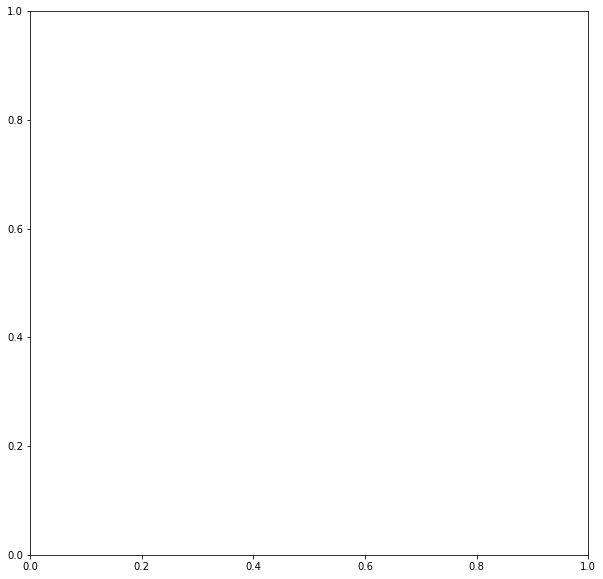

In [18]:
fig, ax = plt.subplots(figsize=(10,10))


In [19]:
df['footprint_area_per_uprn'] = df.footprint_area / df.property_counts

<ipython-input-19-ae90321eaca8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['footprint_area_per_uprn'] = df.footprint_area / df.property_counts


In [20]:
df.footprint_area_per_uprn.describe()

count    34364.000000
mean        55.516700
std        132.468694
min          8.619434
25%         33.093675
50%         46.319210
75%         56.247358
max      12125.372225
Name: footprint_area_per_uprn, dtype: float64

In [21]:
df[~df.buildings_id.duplicated()].footprint_area_per_uprn.sort_values(ascending=False)

21587    12125.372225
30623     5270.868500
7696      4789.423550
11193     3639.098650
33174     2797.440725
             ...     
15617        9.946094
3004         9.735550
17506        9.509107
10508        9.296008
13207        8.619434
Name: footprint_area_per_uprn, Length: 5031, dtype: float64

In [22]:
df.loc[21602]

properties_id                                                       38160465
properties_geometry        0101000020346C000000000000548A144100000000B4FD...
buildings_id                          id4324053F-A993-49B8-B24A-53F7A00AE1B2
buildings_geometry         0103000020346C0000010000000500000052B81E85E089...
dist                                                                     0.0
property_counts                                                           13
footprint_area                                                    2473.02855
footprint_area_per_uprn                                           190.232965
Name: 21602, dtype: object

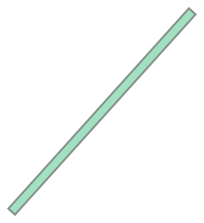

In [23]:
gpd.GeoSeries.from_wkb(df.buildings_geometry).loc[21602]

In [24]:
gdf = gpd.GeoDataFrame(df[~df.buildings_id.duplicated()], geometry=gpd.GeoSeries.from_wkb(df.buildings_geometry))

<AxesSubplot:>

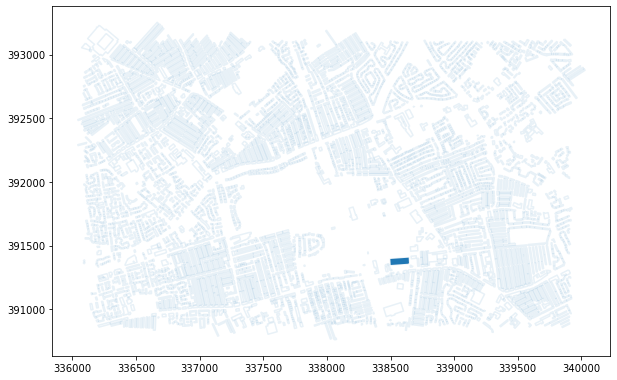

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.geometry.boundary.plot(alpha=0.1, ax=ax)
gdf.loc[15570:15571].plot(ax=ax)

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(335843.6464999999, 340228.10349999997, 390634.1815, 393379.3085000001)

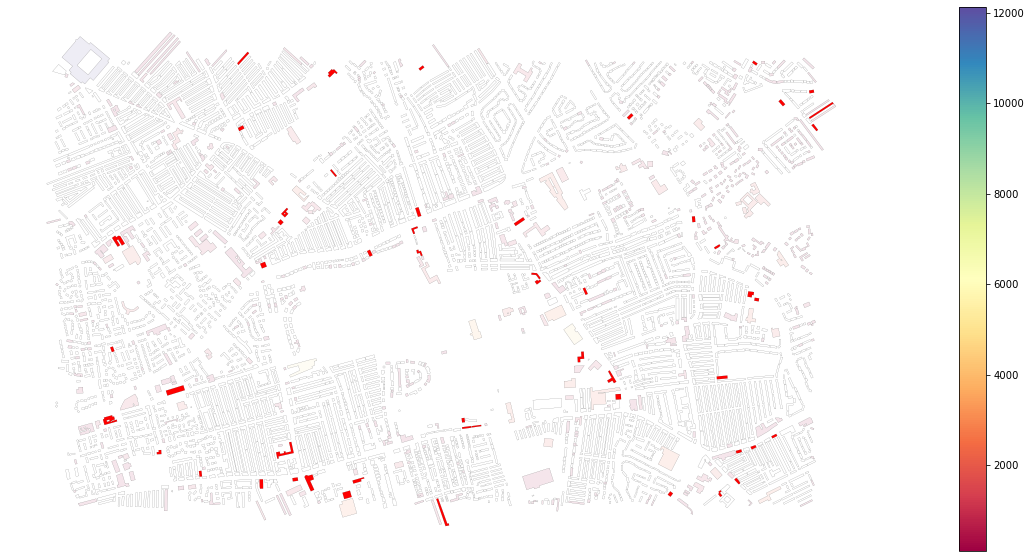

In [26]:
fig, ax = plt.subplots(figsize=(30,10))
gdf[gdf.footprint_area_per_uprn > 100].plot('footprint_area_per_uprn', ax=ax, cmap='Spectral', legend=True, alpha=0.1)
gdf[(gdf.footprint_area_per_uprn < 500) & (gdf.footprint_area_per_uprn > 300)].plot('footprint_area_per_uprn', ax=ax, color='red', legend=True)
gdf.geometry.boundary.plot(ax=ax, color='k', alpha=1, linewidth=0.1)
ax.axis('off')

In [27]:
gdf[(gdf.footprint_area_per_uprn > 100) & (gdf.footprint_area_per_uprn < 200)][['footprint_area','property_counts','footprint_area_per_uprn']]

,footprint_area,property_counts,footprint_area_per_uprn
268,191.68370,1,191.683700
352,433.01440,4,108.253600
390,186.50640,1,186.506400
413,485.49120,4,121.372800
461,117.99500,1,117.995000
...,...,...,...
37294,305.40995,2,152.704975
37297,283.91765,2,141.958825
37317,164.17695,1,164.176950
37391,294.62970,2,147.314850


In [28]:
# eliminate non-residential buildings
building_counts = dict(df.buildings_id.value_counts())
df['building_counts'] = df.buildings_id.apply(lambda x: building_counts.get(x,0))
df['footprint_area'] = gpd.GeoSeries.from_wkb(df.buildings_geometry).area
df['footprint_area_per_uprn'] = df.footprint_area / df.building_counts
df['residential_building'] = df[
    'footprint_area_per_uprn'] < footprint_threshold
df1 = df.loc[df.residential_building].copy()

<ipython-input-28-86e612ef3de4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['building_counts'] = df.buildings_id.apply(lambda x: building_counts.get(x,0))
<ipython-input-28-86e612ef3de4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['footprint_area'] = gpd.GeoSeries.from_wkb(df.buildings_geometry).area
<ipython-input-28-86e612ef3de4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [29]:
# change `building_counts` to `property_counts`
# -- this is confusing, because the repetition of `buildings_id` in the dataframe (suggesting `building_counts`)
# is a consequence of the building having multiple property uprns within it (suggesting `property counts`)
# -- but when you come to calculate the `footprint_area_per_uprn` this should obviously be `per_uprn` or `/ df.property_counts`
# -- which is actually what the *code* is already doing, but in a confusing way.

In [30]:
# eliminate non-residential buildings
building_counts = dict(df.buildings_id.value_counts())
df['property_counts'] = df.buildings_id.apply(lambda x: building_counts.get(x,0))
df['footprint_area'] = gpd.GeoSeries.from_wkb(df.buildings_geometry).area
df['footprint_area_per_uprn'] = df.footprint_area / df.property_counts
df['residential_building'] = df[
    'footprint_area_per_uprn'] < footprint_threshold
df1 = df.loc[df.residential_building].copy()

<ipython-input-30-d9fccf697d54>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['property_counts'] = df.buildings_id.apply(lambda x: building_counts.get(x,0))
<ipython-input-30-d9fccf697d54>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['footprint_area'] = gpd.GeoSeries.from_wkb(df.buildings_geometry).area
<ipython-input-30-d9fccf697d54>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [31]:
# now we establish whether roads are residential; here's the code

In [32]:
print('Getting streets...')
# get streets 
#     bdgs_multiplygn = MultiPolygon(
#         list(gpd.GeoSeries.from_wkb(df1.buildings_geometry).geometry.values))
df2 = db.knn('properties', 'roads', 
             polygon, 
             t2_columns=['"startNode"', '"endNode"'])
df2.loc[df2.properties_id.apply(lambda x: x in df1.properties_id)]

df2 = gpd.GeoDataFrame(df2, geometry=gpd.GeoSeries.from_wkb(df2.roads_geometry))
df2['length'] = df2.geometry.length

# 3 establish whether roads are residential
street_counts = dict(df2.roads_id.value_counts())
df2['street_counts'] = df2.roads_id.apply(
    lambda x: street_counts.get(x, 0))
df2['street_length_per_uprn'] = df2.length / df2.street_counts
df2['residential_street'] = df2.street_length_per_uprn < res_length_threshold
residential = dict(zip(df2.roads_id, df2.residential_street))
df2['residential'] = df2.roads_id.apply(
    lambda x: residential.get(x, False))
df2['short_street'] = df2.length < short_threshold
df2['res_or_short'] = df2.residential | df2.short_street
df3 = df2.loc[df2.res_or_short].copy()

Getting streets...


In [33]:
# comments:
# 1. the commented out MultiPolygon-ing of the buildings_geometry needs to be deleted
# 2. numbered dataframes need to be more clearly named ~ otherwise this is a recipe for confusion
# df is all the properties in the box, with their nearest building, and some added features, 
# specifically `property_counts`, `footprint_area`, `footprint_area_per_uprn`, and `residential_building`
# df1 is the properties connected to residential buildings (as defined by the arbitrary threshold) from df
# df2 is the properties with their nearest road
# 3. df2.loc[df2.properties_id.apply(lambda x: x in df1.properties_id)] is a meaningless line:
# ...i. it doesn't actually assign anything, and ii. it doesn't seem to work anyway 
# (but if we add `.values` then it works!; so could it be useful? specifically, do I want df2 to just include residential properties? or all?)
# 4. to add to the confusion of dataframe names, df2 is then turned into a GeoDataFrame based on its roads_geometry
# 5. and then we again have the same confusion as above in terms of naming counts in a way that is understandable but backwards

In [34]:
print('Getting streets...')
# get streets 
df2 = db.knn('properties', 'roads', 
             polygon, 
             t2_columns=['"startNode"', '"endNode"'])

Getting streets...


In [35]:
df2.loc[df2.properties_id.apply(lambda x: x in df1.properties_id.values)]

,properties_id,properties_geometry,roads_id,startNode,endNode,roads_geometry,dist
0,38000001,0101000020346C0000000000003CB81441000000003CE9...,id0EBE4FE4-65F2-40F0-8FF0-A54FA11B00A8,idD73D5590-526F-496F-997F-7E1F3B4287EC,idFD66B832-1541-419C-A0AB-670FCD03F707,0102000020346C00000300000000000000C4B714410000...,5.794464
1,38000276,0101000020346C000000000000FCBA14410000000000E2...,idC91AED0D-B5BE-457D-827E-63BC083CB177,id3E853882-05E4-4B04-A3DA-D1790327D7AE,idAE5D8D95-077B-4856-B195-6A6516A17A6E,0102000020346C0000030000000000000078BA14410000...,12.100867
2,38000277,0101000020346C0000000000006CBB14410000000034E2...,id4C57AD07-7552-4200-9934-F6783A58AEED,idAE5D8D95-077B-4856-B195-6A6516A17A6E,idC9C1B900-F386-47D8-AC66-178BA124749F,0102000020346C000005000000000000003CBB14410000...,9.765444
3,38000278,0101000020346C000000000000FCBA14410000000018E2...,id116291A0-C738-4161-B2CA-162C291D4C9F,idAE5D8D95-077B-4856-B195-6A6516A17A6E,id23881A15-3638-4DAA-A6EF-A36D9F3E84D6,0102000020346C000003000000000000003CBB14410000...,14.112032
4,38000279,0101000020346C00000000000068BB1441000000004CE2...,id116291A0-C738-4161-B2CA-162C291D4C9F,idAE5D8D95-077B-4856-B195-6A6516A17A6E,id23881A15-3638-4DAA-A6EF-A36D9F3E84D6,0102000020346C000003000000000000003CBB14410000...,14.569901
...,...,...,...,...,...,...,...
37578,38000038,0101000020346C0000000000006891144100000000B4FA...,id1B63F4AE-39FD-4E07-9CBC-6DF6479304A1,idB1762C93-867C-49E9-A91A-3D4E165DAB3F,idD5BA66F0-5FD4-4896-A5FE-4CB76B4643BE,0102000020346C000003000000EC51B81E99911441A470...,18.269867
37579,38000039,0101000020346C000000000000E091144100000000DCFA...,id1B63F4AE-39FD-4E07-9CBC-6DF6479304A1,idB1762C93-867C-49E9-A91A-3D4E165DAB3F,idD5BA66F0-5FD4-4896-A5FE-4CB76B4643BE,0102000020346C000003000000EC51B81E99911441A470...,12.427646
37580,38000040,0101000020346C0000000000005C91144100000000BCFA...,id9060998B-2632-4D29-909C-937977455D09,idB8E2BE4E-EF8B-4473-823C-3BF0F46328B7,idF3B516ED-9FED-4E0C-9254-E54A42E704C0,0102000020346C00000400000000000000A09214410000...,16.027679
37581,38000041,0101000020346C000000000000D491144100000000F0FA...,id1B63F4AE-39FD-4E07-9CBC-6DF6479304A1,idB1762C93-867C-49E9-A91A-3D4E165DAB3F,idD5BA66F0-5FD4-4896-A5FE-4CB76B4643BE,0102000020346C000003000000EC51B81E99911441A470...,12.566592


In [36]:
df2 = gpd.GeoDataFrame(df2, geometry=gpd.GeoSeries.from_wkb(df2.roads_geometry))

In [37]:
df2['length'] = df2.geometry.length

In [38]:
# 3 establish whether roads are residential
street_counts = dict(df2.roads_id.value_counts())
df2['street_property_counts'] = df2.roads_id.apply(
    lambda x: street_counts.get(x, 0))
df2['street_length_per_uprn'] = df2.length / df2.street_property_counts
df2['residential_street'] = df2.street_length_per_uprn < res_length_threshold
residential = dict(zip(df2.roads_id, df2.residential_street))
df2['residential'] = df2.roads_id.apply(
    lambda x: residential.get(x, False))
df2['short_street'] = df2.length < short_threshold
df2['res_or_short'] = df2.residential | df2.short_street
df3 = df2.loc[df2.res_or_short].copy()

In [39]:
# seems to work...

In [40]:
df2[['residential', 'short_street', 'res_or_short']]

,residential,short_street,res_or_short
0,True,False,True
1,True,False,True
2,True,False,True
3,True,False,True
4,True,False,True
...,...,...,...
37578,True,False,True
37579,True,False,True
37580,True,False,True
37581,True,False,True


<AxesSubplot:>

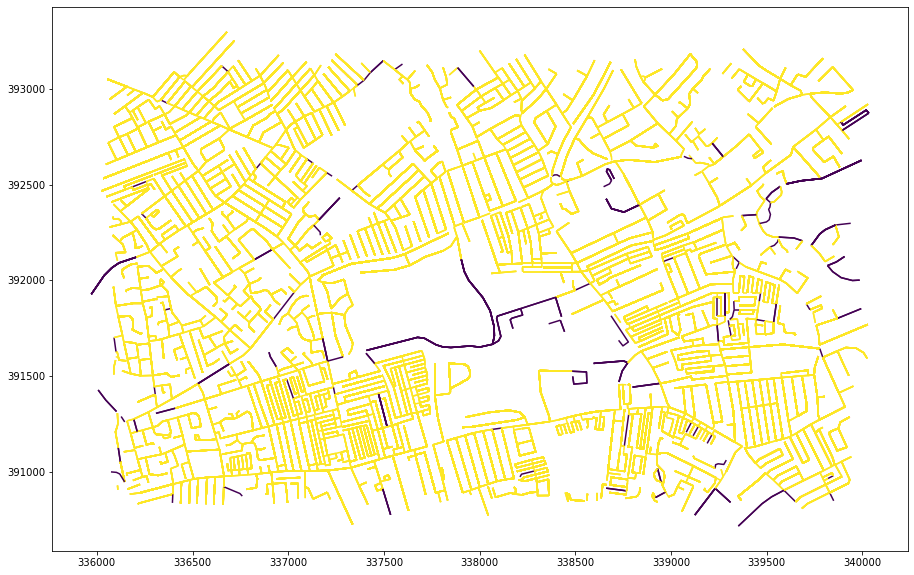

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
df2.plot('res_or_short', ax=ax)

In [42]:
# almost every road is `res_or_short`. this is too many, surely?
# adjust parameters; okay, that's better.
# note that you can see a road that's not visible in C01_NeighbourhoodsFigure...

In [43]:
# and then there's the rest:
# snap nodes, find connected graphs, and label communities

In [44]:
import networkx as nx

from nbhd.geography import nn_translator

In [45]:
print('Snapping nodes...')
# 4 treat nearby nodes as equivalent
translator = nn_translator(db, 'nodes',
    polygon, node_distance)

edges = df3.loc[~df3.duplicated()].copy()
edges['translated_start'] = edges.startNode.apply(
    lambda x: translator.get(x, x))
edges['translated_end'] = edges.endNode.apply(
    lambda x: translator.get(x, x))

print('Finding connected graphs...')
# 5 find connected networks of residential streets
g = nx.from_pandas_edgelist(edges, 'translated_start',
                            'translated_end', True)
subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
sgs = [sg for sg in subgraphs if len(sg) > min_community_size]

print('Labelling communities.')
# 6 add community labels
communities = dict()
for i in range(len(sgs)):
    communities[str(i+1).zfill(2)] = list(
        nx.get_edge_attributes(sgs[i], 'roads_id').values())
communities_key = {
    value: key
    for key, value_list in communities.items() for value in value_list
}
df3['community'] = df3.roads_id.apply(
    lambda x: communities_key.get(x, None))

# merge property~streets df (df3) with property~buildings df (df1)
merged_df = df3.merge(df1, on=['properties_id','properties_geometry'], how='outer')


Snapping nodes...
Finding connected graphs...
Labelling communities.


In [46]:
# the final merge should be 'outer' not 'inner', otherwise it loses roads

<AxesSubplot:>

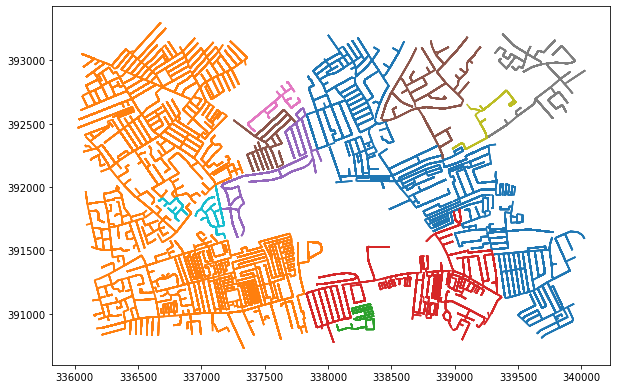

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
df3.plot('community',ax=ax)

<AxesSubplot:>

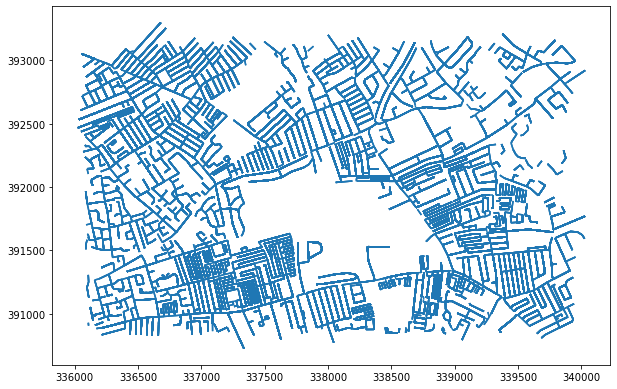

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
merged_df.plot('res_or_short',ax=ax)

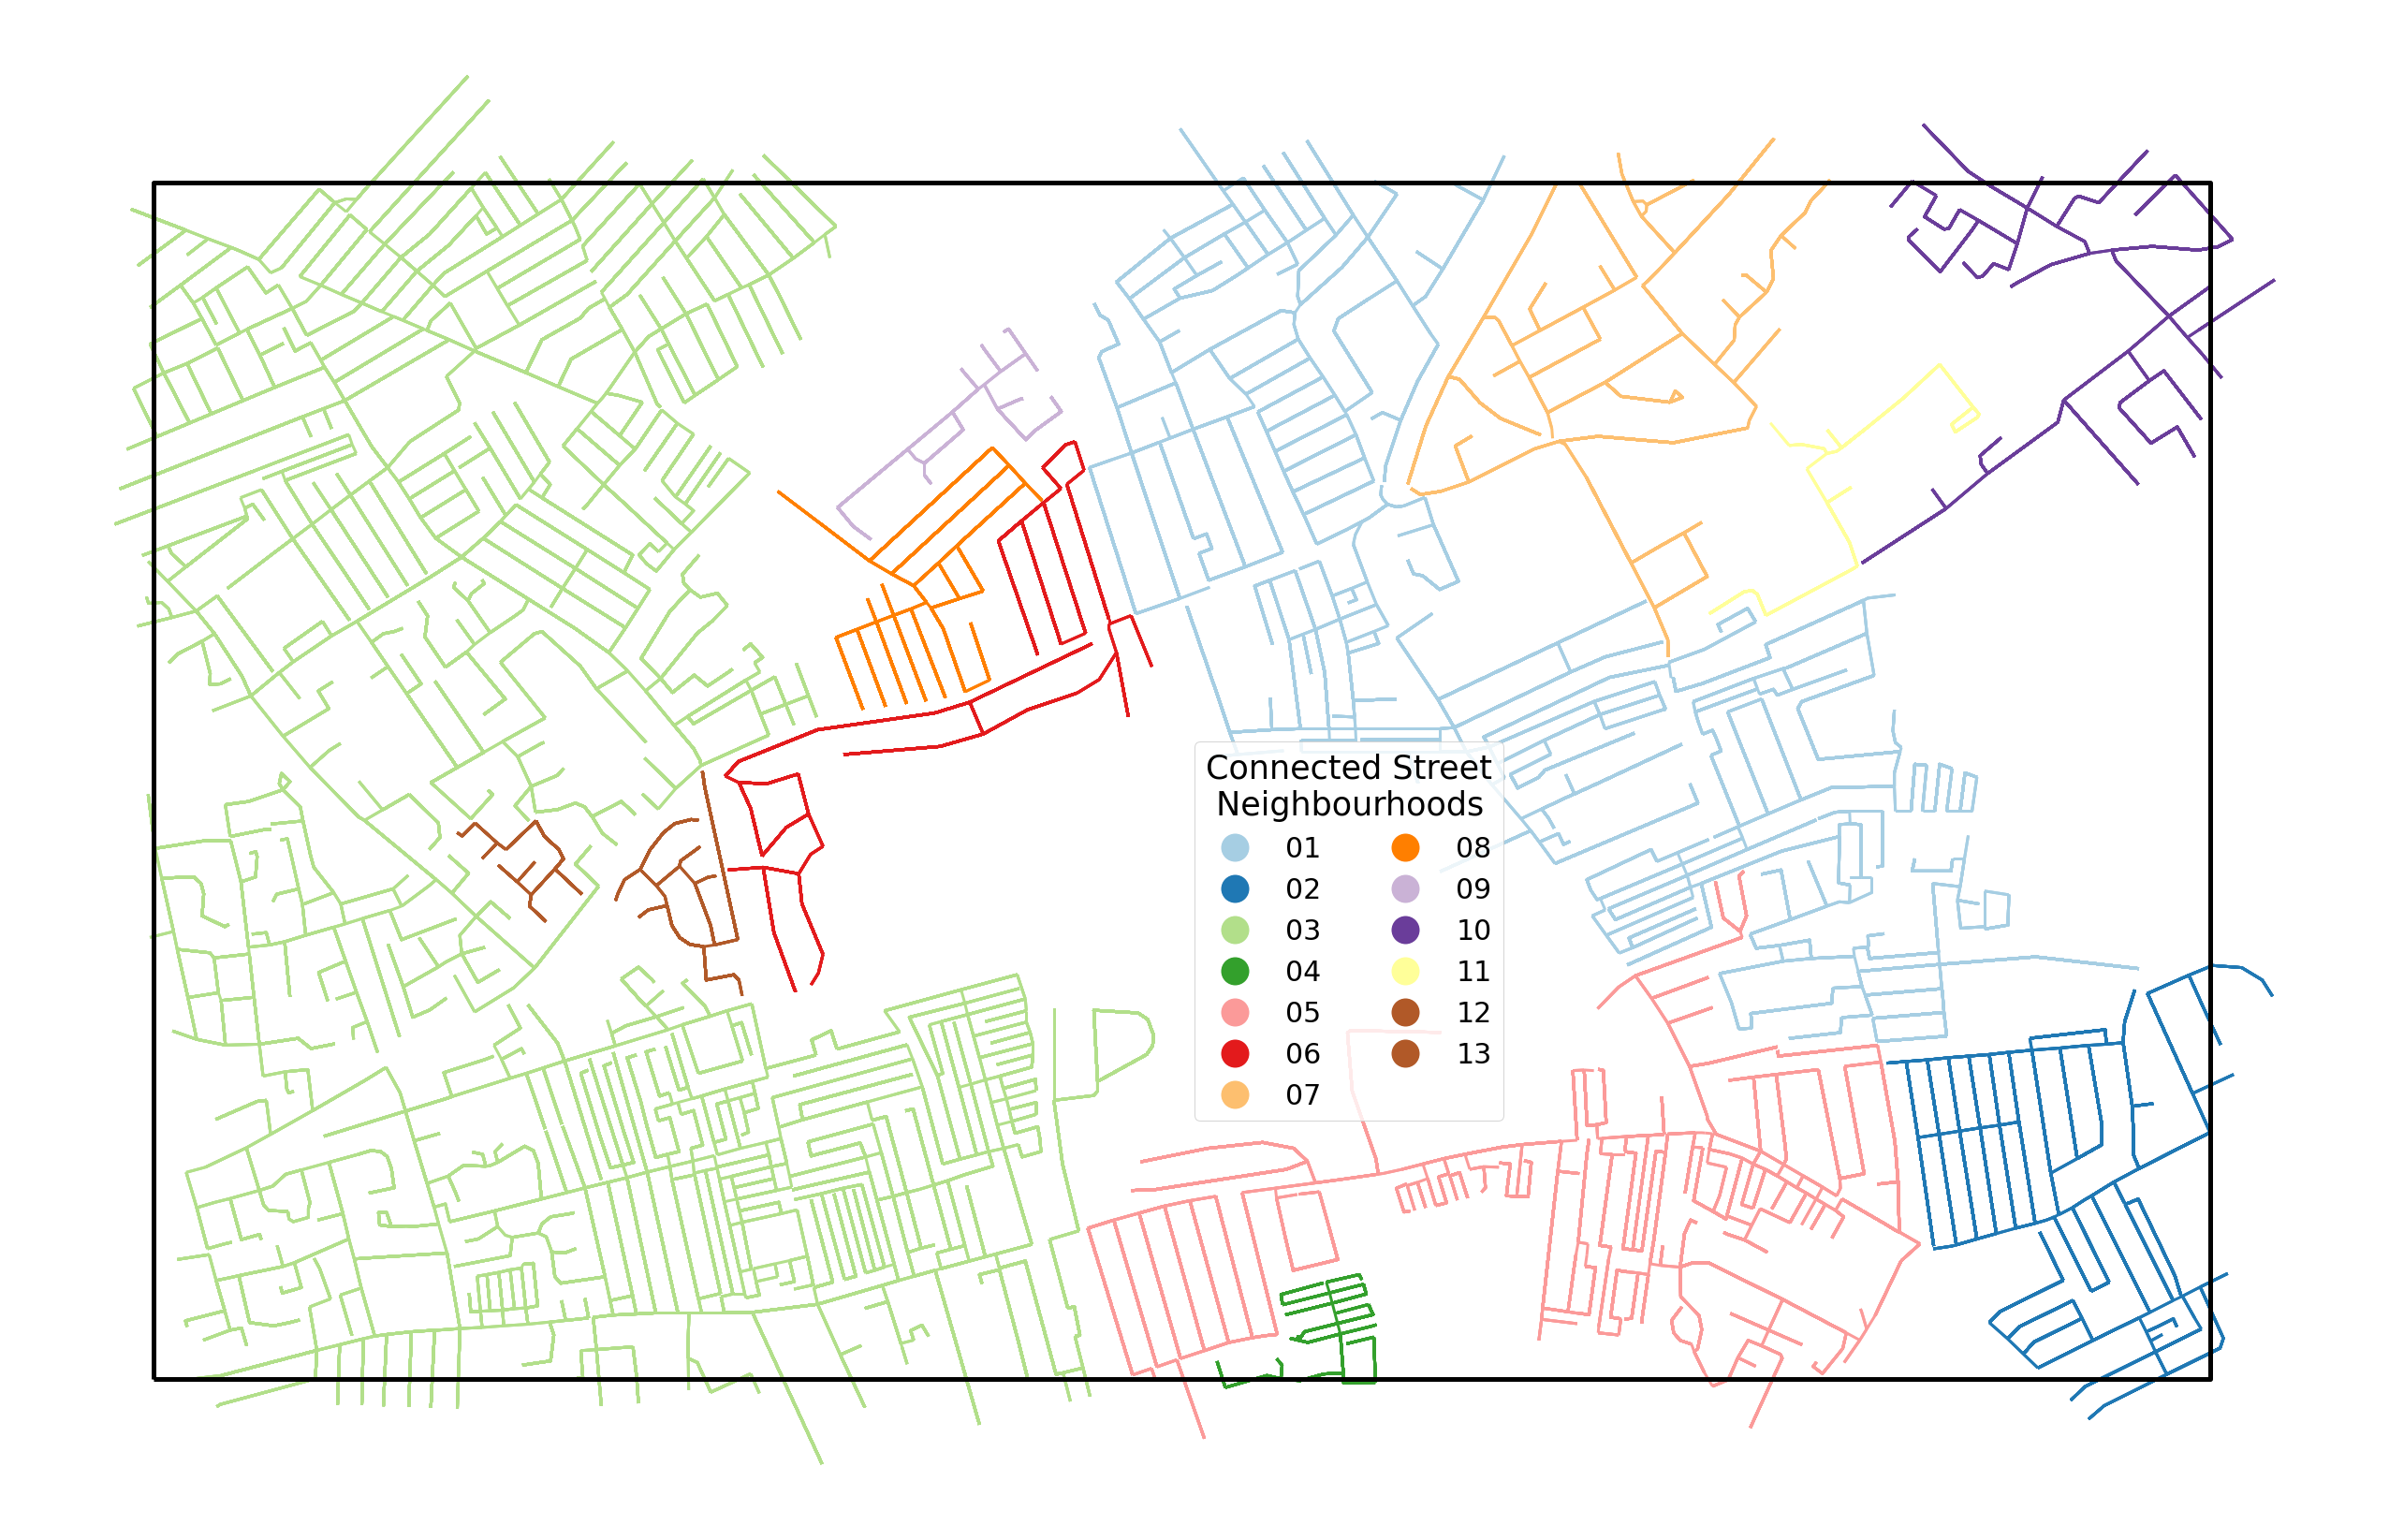

In [54]:
cmap='Paired'
fig, ax = plt.subplots(figsize=(60,30))
merged_df.plot('community', ax=ax, linewidth=3, cmap=cmap, legend=True, 
           legend_kwds={'fontsize':30, 
                        'markerscale':3,
                        'loc':(0.5,0.27),#'best',
                        'title': 'Connected Street\n Neighbourhoods',
                        'title_fontsize':35,
                        'markerfirst': True,
                        'ncol':2})
# properties.plot(color='k', ax=ax, markersize=5)
gpd.GeoSeries(box).boundary.plot(color='k', linewidth=5, ax=ax)
ax.set_axis_off()